In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import math
import random
import pandas as pd
from sklearn.utils import shuffle
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import colors
from matplotlib import cm
import numpy as np
from numpy import linalg as LA
from numpy.linalg import matrix_power
from scipy.linalg import fractional_matrix_power
%cd drive/MyDrive

/content/drive/MyDrive


#Main Algorithms

In [7]:
#algorithm1
def RobustGC(W , y, eta=1):
    row, col = np.diag_indices_from(W)
    D = np.zeros((len(row), len(col)))
    D[row, col] = W.sum(axis=1)
    T = fractional_matrix_power(D, -0.5)
    S = T @ W @ T
    I = np.identity(len(S))
    LN = I - S
    v0 = np.sqrt(np.diagonal(D))
    v0 = v0 / np.sqrt(np.sum(v0**2))
    temp0 = S - v0.dot(v0)
    e = LA.eigvals(temp0)
    e = (np.sort(e))
    a = LA.eigvals(LN)
    lambda1 = (np.sort(a)[1])
    # print(lambda1)
    # print(e[len(e)-1])
    # print(lambda1+e[len(e)-1])
    gamma = eta*lambda1
    temp =LA.inv(LN/gamma - np.identity(len(LN)))
    temp2 = y - v0.dot(v0.dot(y))
    f = temp@temp2
    yhat = np.sign(f)
    return yhat,gamma

def compute_dx(x,dataset,sigma):
    dx = 0
    gamma = 1 / np.power(sigma, 2)
    for i in range(len(dataset)):
        k = np.exp(-gamma * np.linalg.norm(np.array(x) - np.array(dataset[i])))
        dx +=k
    return dx

def out_of_sample(x,dataset,yhat,sigma,gamma ,d_list):
    # with open('data/d_list.pkl', 'rb') as f:
    #     d_list = pickle.load(f)

    dx = compute_dx(x,dataset,sigma)
    temp1 = 1/(1-gamma-(1/dx))

    gamma = 1 / np.power(sigma, 2)
    S = 0
    for i in range(len(dataset)):
        k = np.exp(-gamma * np.linalg.norm(np.array(x) - np.array(dataset[i])))
        s = (k / np.sqrt(dx*d_list[i])) *yhat[i]
        S +=s
    return np.sign(temp1*S)


def dump_d_list(dataset,sigma,num):
    mylist = []
    for i in range(len(dataset)):
        mylist.append(compute_dx(dataset[i],dataset,sigma))
    print(mylist)
    with open('data/d_list_'+str(num)+'.pkl', 'wb') as f:
        pickle.dump(mylist, f)


In [4]:
def sample_labels(label_list,percentage):
    y = np.zeros((len(label_list)), dtype=float)
    negative_indices = [i for i, x in enumerate(label_list) if x == -1]
    positive_indices = [i for i, x in enumerate(label_list) if x == 1]
    n = math.ceil(len(label_list)*(percentage/100))
    a = random.sample(negative_indices, 1)
    b = random.sample(positive_indices, 1)
    y[a] = -1
    y[b] = 1
    negative_indices.remove(a[0])
    positive_indices.remove(b[0])
    positive_indices.extend(negative_indices)
    if n-2 > 0 :
        indices = random.sample(positive_indices, n-2)
        for index in indices :
            if label_list[index] == -1:
                y[index] = -1
            else:
                y[index] = 1
    return y

def find_accuracy(yhat,y_true,y):
    n = sum(y == 0)
    counter =0
    for i,element in enumerate(y):
        if element ==0:
            if yhat[i] == y_true[i]:
                counter+=1
    return (counter/n) * 100


In [5]:
def show_results(labels , mat , landa=0.9  , name_dataset=''):
  sampel_percent=[1,2,5,10,20,50]
  all_acc=[]
  for s in sampel_percent:
    acc = 0
    for i in range(20):
      y = sample_labels(labels,s)
      yhat,_ = RobustGC(mat,y , landa)
      acc += find_accuracy(yhat,labels,y)
    all_acc.append(acc/20)
  if landa ==0.9:
    print("average accuracy for "+str(name_dataset)+" and " +"PF_RobustGC method:"+"\n")
  else:
    print("average accuracy for "+str(name_dataset)+" and " +"RobustGC method:"+"\n")
  if name_dataset not in ("karate" , "polbooks"):
    for j in range(len(sampel_percent)):
      print("percentage: " + str(sampel_percent[j])+" accuracy: "+str(all_acc[j]))
  elif name_dataset=="karate":
    for j in sampel_percent[2:]:
      print("percentage: " + str(j)+" accuracy: "+str(all_acc[sampel_percent.index(j)]))
  else:
    for j in sampel_percent[1:]:
      print("percentage: " + str(j)+" accuracy: "+str(all_acc[sampel_percent.index(j)]))


#Evaluating Algorithm1

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.]


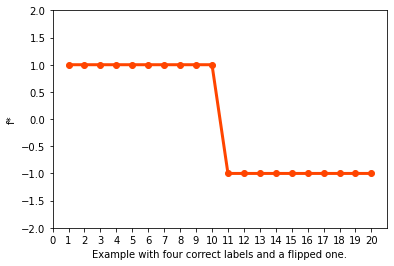

In [9]:
n = 20
x = range(1,n+1)

W = np.zeros((n,n))
for i in range(n-1):
    if i!= 9 :
        W[i][i+1] = 10
        W[i+1][i] = 10
    else:
        W[i][i + 1] = 1
        W[i + 1][i] = 1

y = np.zeros((n),dtype=float)

y [8] = 1
y [11] = -1
y [12] = 1
y [13] = -1
y [14] = -1

yhat ,g= RobustGC(W,y,0.5)
print(yhat)
x = [i for i in range(1,21)]
plt.axis([0, 21, -2, 2])
plt.xticks(np.arange(0,21,1))
plt.plot(x,yhat,'-o',color='orangered',linewidth=3.0)
plt.xlabel('Example with four correct labels and a flipped one.')
plt.ylabel('f*')
plt.savefig('moon.jpg')
plt.show()

# Karate

In [ ]:
y_true = [-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

#karate_club dataset
G = nx.karate_club_graph()

pos = nx.spring_layout(G)

def draw_communities(G, membership, pos):
    """Draws the nodes to a plot with assigned colors for each individual cluster
    Parameters
    ----------
    G : networkx graph
    membership : list
        A list where the position is the student and the value at the position is the student club membership.
        E.g. `print(membership[8]) --> 1` means that student #8 is a member of club 1.
    pos : positioning as a networkx spring layout
        E.g. nx.spring_layout(G)
    """
    fig, ax = plt.subplots(figsize=(16, 9))

    # Convert membership list to a dict where key=club, value=list of students in club
    club_dict = defaultdict(list)
    for student, club in enumerate(membership):
        club_dict[club].append(student)

    # Normalize number of clubs for choosing a color
    norm = colors.Normalize(vmin=0, vmax=len(club_dict.keys()))

    for club, members in club_dict.items():
        nx.draw_networkx_nodes(G, pos,
                               nodelist=members,
                               node_color=cm.jet(norm(club)),
                               node_size=500,
                               alpha=0.8,
                               ax=ax)

    # Draw edges (social connections) and show final plot
    plt.title("Zachary's Karate Club")
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)


def graph_to_edge_matrix(G):
    """Convert a networkx graph into an edge matrix.
    Parameters
    ----------
    G : networkx graph
    """
    # Initialize edge matrix with zeros
    edge_mat = np.zeros((len(G), len(G)), dtype=int)

    # Loop to set 0 or 1 (diagonal elements are set to 1)
    for node in G:
        for neighbor in G.neighbors(node):
            edge_mat[node][neighbor] = 1
        edge_mat[node][node] = 1
    return edge_mat

# USPS

In [ ]:
#usps

def make_dataset(data_path='usps',new_file_path='out.txt',numberOfsamples=125):

    with open(data_path) as f:
        data = f.readlines()
    counter4 = 0
    counter9 = 0
    with open(new_file_path, "w") as f1:
        for i in range(len(data)):
            if data[i][0] == '4' and counter4 <numberOfsamples:
                f1.write(data[i])
                counter4+=1
                print(counter4)
            if data[i][0] == '9' and counter9 <numberOfsamples:
                f1.write(data[i])
                counter9+=1
                print(counter9)
    f.close()
    f1.close()

def read_data(filepath):

    with open(filepath) as f:
        data = f.readlines()

    vectors  = np.zeros((len(data), 256), dtype=float)

    for i in range(len(data)):
        d = data[i].split(':')
        v = []
        for j in range(1, len(d)):
            v.append(float(d[j].split(' ')[0]))
        vectors[i] = v

    return vectors


def generate_weight_mat(vectors,sigma):

    gamma = 1/np.power(sigma,2)
    weight_mat = np.zeros((len(vectors),len(vectors)),dtype=float)
    for i in range(len(vectors)):
        for j in range(len(vectors)):
            weight_mat[i][j] = np.exp(-gamma * np.linalg.norm(np.array(vectors[i])-np.array(vectors[j])))
    return weight_mat

def generate_labels(filepath):
    labels = []
    c = 0
    d = 0
    with open(filepath) as file_in:

        for line in file_in:
            l = (line[0])
            if l == '4':
                c += 1
                labels.append(-1)
            if l == '9':
                labels.append(1)
                d += 1
    return labels

#dolphins

In [ ]:
def dolphins_labels_and_matrix():
  labels = []
  with  open("dolphins.edges" , "r") as f:
    adjacency= f.readlines()
  # Initialize edge matrix with zeros
  edge_mat = np.zeros((62, 62), dtype=int)

  for edge in adjacency:
    a = edge.replace("\n" , "").split("\t")
    edge_mat[int(a[0])][int(a[1])]= 1
    edge_mat[int(a[1])][int(a[0])]= 1

  for i in range(len(edge_mat)):
    edge_mat[i][i] =1

  with  open("dolphins.clusters" , "r") as f:
    label_polblog = f.readlines()
  #print(label_polblog)
  for label in label_polblog:
      a = label.replace("\n", "")
      temp =int(a.split("\t")[1])
      if temp == 1:
          labels.append(-1)
      else:
          labels.append(1)

  return labels, edge_mat


# polbooks

In [ ]:
def polbooks_labels_and_matrix():

  with open("polbooks.clusters" , "r" ) as f:
    polbooks_labels = f.readlines()
  delete_label = []
  temp={}
  for i in polbooks_labels:
    a =i.replace("\n", "").split("\t")
    temp[int(a[0])] = int(a[1])
  labels_ = [ v for k, v in sorted(temp.items(), key=lambda item: item[0])]

  with open("polbooks.edges" , "r") as f:
    polbooks_mat=f.readlines()

  edge_mat = np.zeros((105, 105), dtype=int)
  
  for i in polbooks_mat:
    a = i.replace("\n" , "").split("\t")
    edge_mat[int(a[0])][int(a[1])] = 1
    edge_mat[int(a[1])][int(a[0])] = 1
  for i in range(len(edge_mat)):
    edge_mat[i][i] = 1

  #define indexes that must be delete to create new matrix and labels
  for k , v in enumerate(labels_):
    if v == 0  :
      delete_label.append(k)
      
  #create new mat and labels with 92 nodes  
  edge_mat = np.delete(edge_mat ,delete_label , 0 )
  edge_mat = np.delete(edge_mat ,delete_label , 1 )
  labels= [i for i in labels_ if i!=0]
  labels = [-1 if i==2  else 1 for i in labels]

  return labels, edge_mat


# Part 4.1

In [ ]:
def sample_labels_noise(label_list,percentage  , rate_noise=0 , with_noise=0):
    y = np.zeros((len(label_list)), dtype=float)
    negative_indices = [i for i, x in enumerate(label_list) if x == -1]
    positive_indices = [i for i, x in enumerate(label_list) if x == 1]
    n = math.ceil(len(label_list)*(percentage/100))
    a = random.sample(negative_indices, 1)
    b = random.sample(positive_indices, 1)
    y[a] = -1
    y[b] = 1
    negative_indices.remove(a[0])
    positive_indices.remove(b[0])
    positive_indices.extend(negative_indices)

    if with_noise==0:
      if n-2 > 0 :     
          indices = random.sample(positive_indices, n-2)
          for index in indices :
              if label_list[index] == -1:
                  y[index] = -1
              else:
                  y[index] = 1
    else:
      ns = math.ceil((len(label_list)-(n-2)) * (rate_noise/100))
      if n-2 > 0 :     
        indices = random.sample(positive_indices, n-2)
        for index in indices :
            if label_list[index] == -1:
                y[index] = -1
            else:
                y[index] = 1
        for i in indices :
          positive_indices.remove(i)
      if ns > 0 :
        indices = random.sample(positive_indices, ns)
        for index in indices:
          if label_list[index] ==-1:
            y[index] = 1
          else:
            y[index] = -1
    return y

In [ ]:
noise_lst = [10,20,30,40]
sample_label_lst= [5,10,20,25,30,40,50,60]

In [ ]:
def ploting(x ,y , z):
  for i  in range(len(y)):
    plt.plot(x , y[i] , "-" , c="r" )
    plt.plot(x , z[i] , "-" , c="b")
    plt.legend(["RobustGC","FP_RobustGC"])
    plt.plot(x , y[i] , "o" , c="g")
    plt.plot(x , z[i] , "o" , c="r")
    plt.title(str(noise_lst[i]) + "% noise" )
    plt.xlabel("No.labels")
    plt.ylabel("acc")
    plt.show()

In [ ]:
def test_RobustGC_with_noise(labels , mat):
  acc_all_for_RobustGC = []
  acc_all_for_FP_RobustGC = []
  for noise in noise_lst:
    acc_means_algo1 =[]
    acc_means_algo2=[]
    for s_label in sample_label_lst:
      acc_algo1=0
      acc_algo2=0
      for i in range(50):
        y  = sample_labels_noise(labels,s_label , noise , 1)
        yhat  , _= RobustGC(mat,y , 0.5)
        acc_algo1 += find_accuracy(yhat,labels,y)
        #FP_RobustGC
        yhat  , _= RobustGC(mat,y , 0.9)
        acc_algo2 += find_accuracy(yhat,labels,y)

      acc_means_algo1.append(acc_algo1/50)
      acc_means_algo2.append(acc_algo2/50)
    acc_all_for_RobustGC.append(acc_means_algo1)
    acc_all_for_FP_RobustGC.append(acc_means_algo2)
  ploting(sample_label_lst,acc_all_for_RobustGC , acc_all_for_FP_RobustGC )

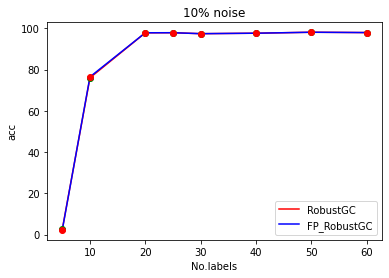

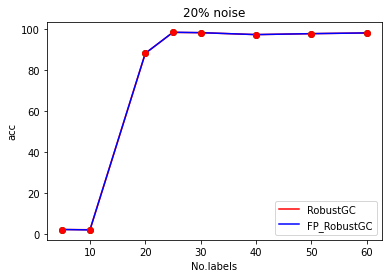

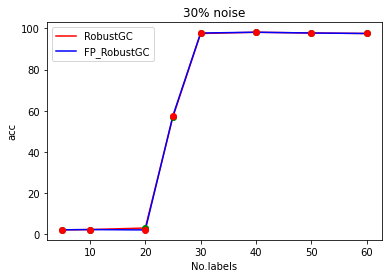

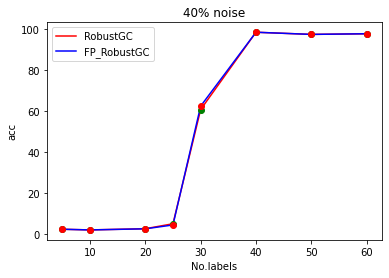

In [ ]:
labels , mat = polbooks_labels_and_matrix()
test_RobustGC_with_noise(labels , mat)

#Part 4.2

In [ ]:
labels , mat = polbooks_labels_and_matrix()
show_results(labels , mat , landa=0.5  , name_dataset="polbooks")
print("*"*60)
show_results(labels , mat , landa=0.9 , name_dataset="polbooks")

average accuracy for polbooks and RobustGC method:

percentage: 2 accuracy: 97.7777777777778
percentage: 5 accuracy: 97.87356321839083
percentage: 10 accuracy: 98.04878048780485
percentage: 20 accuracy: 98.15068493150686
percentage: 50 accuracy: 98.15217391304348
************************************************************
average accuracy for polbooks and PF_RobustGC method:

percentage: 2 accuracy: 97.83333333333336
percentage: 5 accuracy: 97.98850574712647
percentage: 10 accuracy: 97.74390243902437
percentage: 20 accuracy: 97.94520547945206
percentage: 50 accuracy: 97.71739130434783


In [ ]:
mat = graph_to_edge_matrix(G)
labels = [-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
show_results(labels , mat , landa=0.5  , name_dataset="karate")
print("*"*60)
show_results(labels , mat , landa=0.9 , name_dataset="karate")

average accuracy for karate and RobustGC method:

percentage: 5 accuracy: 97.96875
percentage: 10 accuracy: 98.50000000000003
percentage: 20 accuracy: 99.07407407407408
percentage: 50 accuracy: 98.52941176470588
************************************************************
average accuracy for karate and PF_RobustGC method:

percentage: 5 accuracy: 97.65625
percentage: 10 accuracy: 97.66666666666669
percentage: 20 accuracy: 97.77777777777777
percentage: 50 accuracy: 96.76470588235293


In [ ]:
filePath="out.txt"
vectors = read_data(filePath)
mat = generate_weight_mat(vectors, sigma=1.25)
labels = (generate_labels(filePath))
show_results(labels , mat , landa=0.5  , name_dataset="digite49-w")
print("*"*60)
show_results(labels , mat , landa=0.9 , name_dataset="digite49-w")

average accuracy for digite49-w and RobustGC method:

percentage: 1 accuracy: 87.44939271255062
percentage: 2 accuracy: 90.6734693877551
percentage: 5 accuracy: 93.2067510548523
percentage: 10 accuracy: 93.84444444444443
percentage: 20 accuracy: 93.8
percentage: 50 accuracy: 94.92
************************************************************
average accuracy for digite49-w and PF_RobustGC method:

percentage: 1 accuracy: 89.67611336032388
percentage: 2 accuracy: 92.32653061224491
percentage: 5 accuracy: 91.9831223628692
percentage: 10 accuracy: 93.37777777777778
percentage: 20 accuracy: 93.425
percentage: 50 accuracy: 94.11999999999999


In [ ]:
labels , mat = dolphins_labels_and_matrix()
show_results(labels , mat , landa=0.5  , name_dataset="dolphins")
print("*"*60)
show_results(labels , mat , landa=0.9 , name_dataset="dolphins")

average accuracy for dolphins and RobustGC method:

percentage: 1 accuracy: 96.58333333333334
percentage: 2 accuracy: 96.66666666666669
percentage: 5 accuracy: 96.98275862068964
percentage: 10 accuracy: 96.63636363636361
percentage: 20 accuracy: 96.73469387755102
percentage: 50 accuracy: 96.4516129032258
************************************************************
average accuracy for dolphins and PF_RobustGC method:

percentage: 1 accuracy: 96.75000000000003
percentage: 2 accuracy: 96.6666666666667
percentage: 5 accuracy: 96.72413793103445
percentage: 10 accuracy: 96.8181818181818
percentage: 20 accuracy: 96.93877551020408
percentage: 50 accuracy: 96.77419354838709
